<h2 style="text-align:center;color:blue;">Objectif :</h2>

<h3 style="text-align:center;">        In this competition we will be ranking comments in order of severity of toxicity. We are given a list of comments, and each comment should be scored according to their relative toxicity. Comments with a higher degree of toxicity should receive a higher numerical value compared to comments with a lower degree of toxicity.</h3>
    
  <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSblnNX1zqaG70dan0DywBXM1VP75dbjCYbkA&usqp=CAU" width="400"></img>

<p style="background-color:orange; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><b>Importing Libraries & Data</b></p> 

In [1]:
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gensim

from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, Dropout, Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [2]:
dff = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
dff.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<p style="background-color:orange; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><b>Quick EDA</b></p> 

In [3]:
dff.shape

(159571, 8)

In [4]:
dff.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
dff.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
dff.severe_toxic.value_counts()

0    157976
1      1595
Name: severe_toxic, dtype: int64

In [7]:
dff['toxicity'] = (dff[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
dff = dff[['comment_text', 'toxicity']].rename(columns={'comment_text': 'text'})
dff.sample(5)

,text,toxicity
67922,Knepp Castle \n\nI'm not sure if you're still ...,0
63521,Ask O'Dea Hackney he cited it as his reason. M...,0
157206,""" It is a """"Biblical scientific foreknowledge""...",0
92152,"""\n\nI've been too busy to take part in that d...",0
129979,"Category:People from Westfield, Wisconsin\n\n:...",0


In [8]:
dff.describe()

,toxicity
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [9]:
dff.head()

,text,toxicity
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [10]:
dff.toxicity.value_counts()

0    143346
1     16225
Name: toxicity, dtype: int64

Our data is not balanced.

In [11]:
min_len = (dff['toxicity'] == 1).sum()
df_undersample = dff[dff['toxicity'] == 0].sample(n=min_len, random_state=201)
dff = pd.concat([df_undersample, dff[dff['toxicity'] == 1]])
dff = shuffle(dff)

In [12]:
dff.text = dff.text.map(lambda x:x.replace('\n', ' '))
dff.text[:2]

47359     ", 25 April 2014 (UTC) Support because a myth ...
124025    Roisterer is a prime example of why this place...
Name: text, dtype: object

In [13]:
toxic = dff[dff['toxicity'] == 1]
not_toxic = dff[dff['toxicity'] == 0]

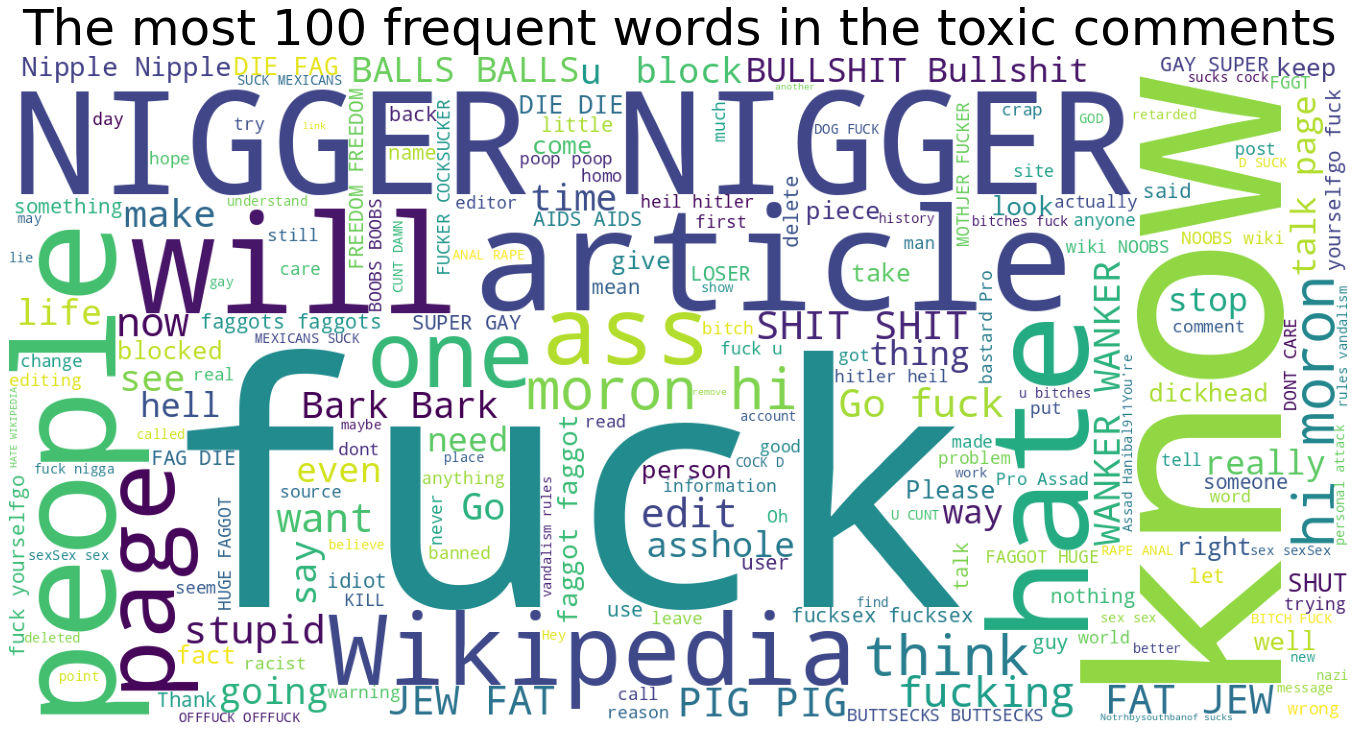

In [14]:
wordcloud = WordCloud(width=1400, height=700, background_color='white').generate(' '.join(toxic.text.tolist()))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud)
plt.axis('off')
plt.title('The most 100 frequent words in the toxic comments', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

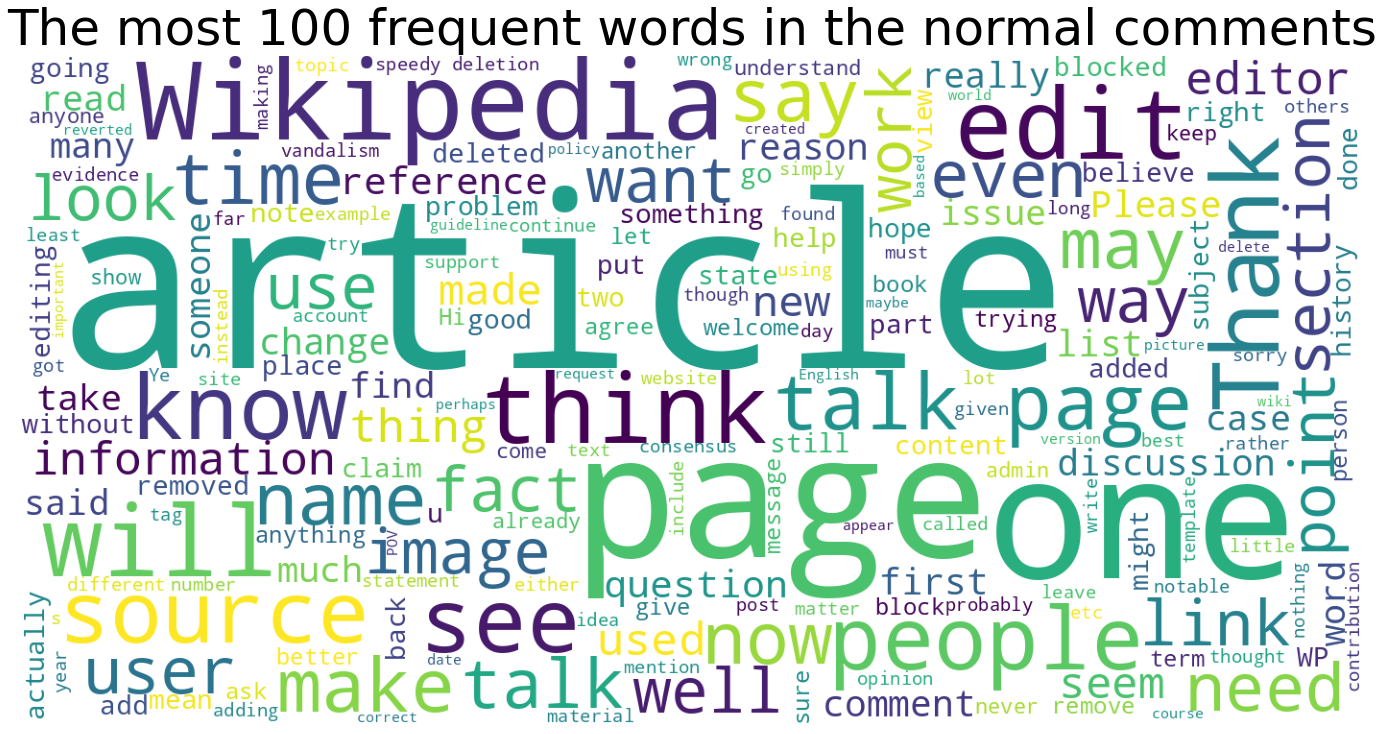

In [15]:
wordcloud = WordCloud(width=1400, height=700, background_color='white').generate(' '.join(not_toxic.text.tolist()))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud)
plt.axis('off')
plt.title('The most 100 frequent words in the normal comments', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

<p style="background-color:orange; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><b>Text Pre-Processing</b></p> 

We get our X and y variables, then create a copy to work on it :

In [16]:
y = dff.toxicity
x = dff.drop('toxicity', axis = 1)

In [17]:
texts = x.copy()
texts.reset_index(inplace = True, drop = True)
texts.head()

,text
0,""", 25 April 2014 (UTC) Support because a myth ..."
1,Roisterer is a prime example of why this place...
2,Thanks for sorting that out - I don't often no...
3,""" As I said, it was an in joke. I and my fri..."
4,Good to see the neo-Nazi Wikipedia editors all...


In order to not get a RecursionError, we reset our recursionlimit to 6000.

In [18]:
print(sys.getrecursionlimit())

3000


In [19]:
sys.setrecursionlimit(6000)

When dealing with text, we should first do some cleaning and stemming :

### What Is Stemming ?

The process of removing a part of a word, or reducing a word to its stem or root.

### Example :

Let’s assume we have a set of words — **send, sent and sending**. All three words are different tenses of the same root word **send**. So after we stem the words, we’ll have just the one word — send. 

In [20]:
ps = PorterStemmer()
corpus = []

for i in tqdm(range(0, len(texts))) :
    cleaned = re.sub('[^a-zA-Z]', ' ', texts['text'][i])
    cleaned = cleaned.lower().split()
    
    cleaned = [ps.stem(word) for word in cleaned if not word in stopwords.words('english')]
    cleaned = ' '.join(cleaned)
    corpus.append(cleaned)

100%|██████████| 32450/32450 [04:34<00:00, 118.18it/s]


Our model will not be able to deal with text, it should have numbers as input, that's why we do first word embedding.

### What is Word Embedding ?

Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.


Word Embeddings are vector representations of a particular word. 

In [21]:
DIM = 100

X = [d.split() for d in corpus]
w2v_model = gensim.models.Word2Vec(sentences = X, vector_size = DIM, window = 10, min_count = 1)

Let's see how many words in our vocabulary :

In [22]:
len(w2v_model.wv.key_to_index.keys()) 

46216

We can find similar words to a specific one, let's try with the word 'toxic' :

In [23]:
w2v_model.wv.most_similar('toxic')

[('thin', 0.9656485915184021),
 ('drama', 0.9627013206481934),
 ('caught', 0.9618170261383057),
 ('scream', 0.9614737033843994),
 ('assoc', 0.9597153663635254),
 ('afterward', 0.9595393538475037),
 ('forcibl', 0.9591641426086426),
 ('patron', 0.9587470293045044),
 ('kitt', 0.9556828141212463),
 ('quiet', 0.9555528163909912)]

Now we tokenize the sentences and convert X into sequences of numbers :

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X) 

In [25]:
X = tokenizer.texts_to_sequences(X)
X[:3]

[[993,
  175,
  196,
  2360,
  2360,
  372,
  372,
  507,
  9,
  22742,
  615,
  110,
  219,
  68,
  217,
  2360,
  528,
  918,
  377,
  1250,
  2360,
  1216,
  2360,
  5367,
  569,
  16041,
  9,
  2360,
  753,
  396],
 [16042,
  1909,
  273,
  95,
  2557,
  223,
  16042,
  13,
  26,
  434,
  275,
  3626,
  45,
  490,
  167,
  602,
  1276,
  269,
  6160,
  22743,
  120,
  135,
  4468,
  74,
  96,
  29,
  89,
  112,
  959,
  121,
  436,
  22744,
  2531,
  7376,
  393,
  8695,
  22745,
  749,
  1041,
  27,
  67,
  8,
  108,
  1848,
  1346,
  1262,
  625,
  1034,
  16043,
  1638,
  1927,
  454,
  416,
  3482,
  303,
  37],
 [28, 508, 777, 584, 15, 314, 580, 526, 14, 3985, 466, 931, 238]]

Let's convert all the sentences to have the same length which is 20 in our case :

In [26]:
X = pad_sequences(X, padding = 'pre', maxlen = 20)
X[:3]

array([[  615,   110,   219,    68,   217,  2360,   528,   918,   377,
         1250,  2360,  1216,  2360,  5367,   569, 16041,     9,  2360,
          753,   396],
       [22745,   749,  1041,    27,    67,     8,   108,  1848,  1346,
         1262,   625,  1034, 16043,  1638,  1927,   454,   416,  3482,
          303,    37],
       [    0,     0,     0,     0,     0,     0,     0,    28,   508,
          777,   584,    15,   314,   580,   526,    14,  3985,   466,
          931,   238]], dtype=int32)

We will feed these vectors as initial weights to our model then recreate these vectors to get better accuracy :

In [27]:
vocab_size = len(tokenizer.word_index) + 1 
vocab = tokenizer.word_index

In [28]:
def get_weights_matrix(model) :
    weights_matrix = np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items() :
        weights_matrix[i] = model.wv[word]
        
    return weights_matrix


embedding_vectors = get_weights_matrix(w2v_model) 

<p style="background-color:orange; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><b>Modeling & Training</b></p> 

In [29]:
model = Sequential()

model.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vectors], input_length = 20)) 
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))

2021-11-20 07:43:29.169156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 07:43:29.300307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 07:43:29.301092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 07:43:29.302398: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [30]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           4621700   
_________________________________________________________________
dropout (Dropout)            (None, 20, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

es = EarlyStopping(patience=3, 
                   monitor='loss', 
                   restore_best_weights=True, 
                   mode='min', 
                   verbose=1)

# train the model 
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 15,
                 callbacks=es, batch_size = 32, shuffle=True)

2021-11-20 07:43:34.686932: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2021-11-20 07:43:36.959735: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


812/812 [==============================] - 9s 6ms/step - loss: 0.1210 - accuracy: 0.8443 - val_loss: 0.0885 - val_accuracy: 0.8820
Epoch 2/15
812/812 [==============================] - 5s 6ms/step - loss: 0.0838 - accuracy: 0.8953 - val_loss: 0.0841 - val_accuracy: 0.8924
Epoch 3/15
812/812 [==============================] - 5s 6ms/step - loss: 0.0574 - accuracy: 0.9334 - val_loss: 0.0848 - val_accuracy: 0.8892
Epoch 4/15
812/812 [==============================] - 5s 7ms/step - loss: 0.0378 - accuracy: 0.9564 - val_loss: 0.0884 - val_accuracy: 0.8903
Epoch 5/15
812/812 [==============================] - 5s 6ms/step - loss: 0.0271 - accuracy: 0.9701 - val_loss: 0.0953 - val_accuracy: 0.8846
Epoch 6/15
812/812 [==============================] - 5s 7ms/step - loss: 0.0222 - accuracy: 0.9769 - val_loss: 0.0996 - val_accuracy: 0.8792
Epoch 7/15
812/812 [==============================] - 5s 6ms/step - loss: 0.0194 - accuracy: 0.9801 - val_loss: 0.1030 - val_accuracy: 0.8778
Epoch 8/15
812/81

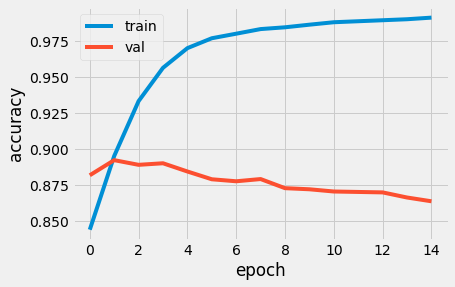

In [32]:
plt.style.use('fivethirtyeight')

# visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()  

<p style="background-color:orange; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><b>Submission</b></p> 

In [33]:
sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

In [34]:
new_text = tokenizer.texts_to_sequences(sub.text)
new_text = pad_sequences(new_text, maxlen = 20)

In [35]:
sub['score'] = model.predict(new_text) * 1000 
sub.head()

,comment_id,text,score
0,114890,"""\n \n\nGjalexei, you asked about whether ther...",985.255554
1,732895,"Looks like be have an abuser , can you please ...",953.735962
2,1139051,I confess to having complete (and apparently b...,12.103960
3,1434512,"""\n\nFreud's ideas are certainly much discusse...",986.585205
4,2084821,It is not just you. This is a laundry list of ...,987.212402


In [36]:
sub[['comment_id', 'score']].to_csv("submission.csv", index=False)

## Please If You Like This Notebook, Please don't Forget To Upvote It ;